## BTC Algorithm - Study V3.3

## Import Python Libraries

In [8]:
import numpy as np

import pandas as pd
pd.set_option("display.max_columns", 30)

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import mplfinance as fplt

# import pandas_datareader as pdr

## Load dataset

In [9]:
df = pd.read_csv('../resources/dataset/2018-2022_1min.csv')

df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df = df.set_index('open_time', drop=True)

In [10]:
print(df.shape)

timeframe = 15 # Minutes
df = df.groupby(pd.Grouper(freq=f'{timeframe}min', origin='start', label='right')).agg(
    {'close_price':'last',
    'high_price':'max',
    'low_price':'min',
    'open_price':'first',
    'taker_buy_base_asset_volume':'sum',
    'volume':'sum',
    'trades':'sum'}
)

df.head(5)

(2586873, 11)


,close_price,high_price,low_price,open_price,taker_buy_base_asset_volume,volume,trades
open_time,,,,,,,
2018-01-01 00:15:00,13556.15,13715.65,13400.01,13715.65,63.227133,123.616013,1572
2018-01-01 00:30:00,13521.12,13550.87,13402.00,13533.75,47.686389,98.136430,1461
2018-01-01 00:45:00,13470.41,13545.37,13450.00,13500.00,43.710406,79.904037,1000
2018-01-01 01:00:00,13529.01,13690.87,13450.00,13494.65,73.897993,141.699719,1195
2018-01-01 01:15:00,13445.63,13571.74,13402.28,13528.99,34.257652,72.537533,898


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172993 entries, 2018-01-01 00:15:00 to 2022-12-08 00:15:00
Freq: 15T
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   close_price                  172466 non-null  float64
 1   high_price                   172466 non-null  float64
 2   low_price                    172466 non-null  float64
 3   open_price                   172466 non-null  float64
 4   taker_buy_base_asset_volume  172993 non-null  float64
 5   volume                       172993 non-null  float64
 6   trades                       172993 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 10.6 MB


In [12]:
btc_return = df['close_price'].copy()
btc_return = round(np.log(btc_return).diff() * 100, 2)
btc_return = btc_return.dropna()
btc_return[:5]

open_time
2018-01-01 00:30:00   -0.26
2018-01-01 00:45:00   -0.38
2018-01-01 01:00:00    0.43
2018-01-01 01:15:00   -0.62
2018-01-01 01:30:00    0.85
Name: close_price, dtype: float64

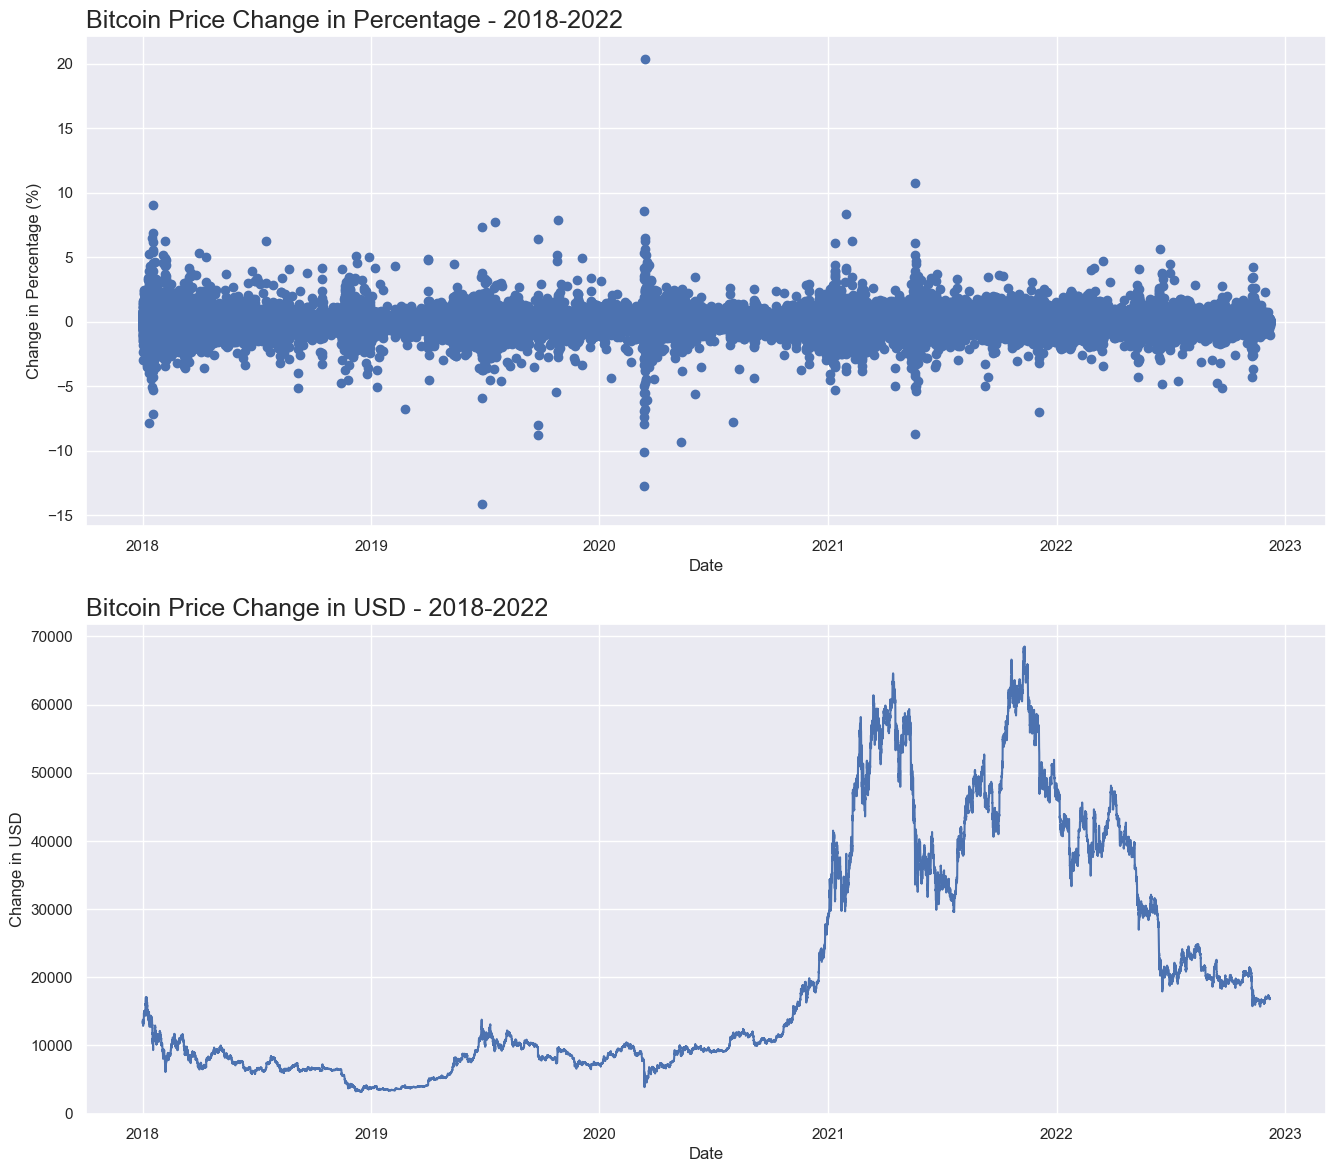

In [13]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(16, 14)})

fig, (ax1, ax2) = plt.subplots(2)

ax1.scatter(x=btc_return.index, y=btc_return)
ax1.set(xlabel='Date', ylabel='Change in Percentage (%)')
ax1.set_title('Bitcoin Price Change in Percentage - 2018-2022', fontsize=18, loc='left')

ax2.plot(df[::7].index, df[::7]['close_price'])
ax2.set(xlabel='Date', ylabel='Change in USD')
ax2.set_title('Bitcoin Price Change in USD - 2018-2022', fontsize=18, loc='left');

## Interesting fact

The periods of most volatility is when Bitcoin is trending on Google.

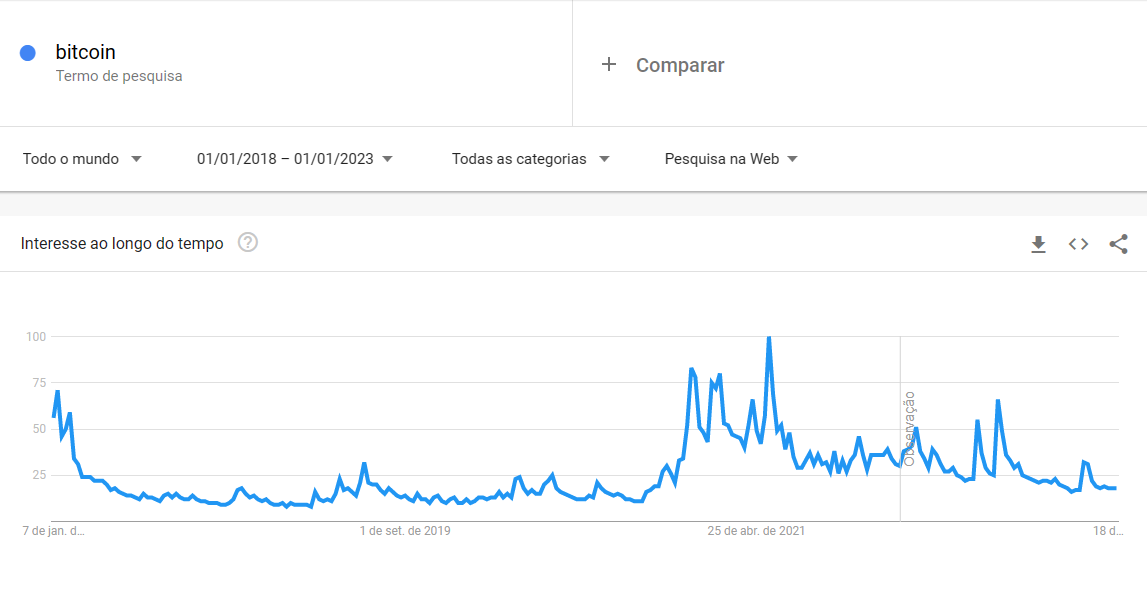

## Is price change normally distributed?

In [14]:
from scipy import stats
from scipy.stats import norm

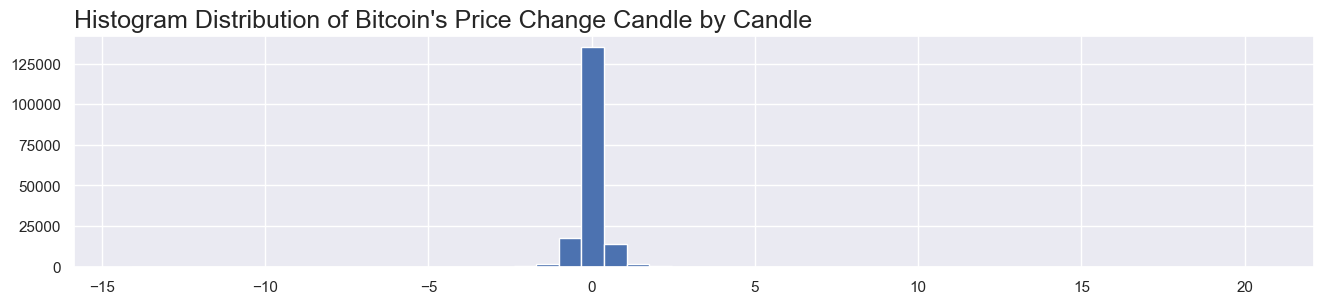

In [15]:
sns.set(rc={'figure.figsize':(16, 3)})

plt.hist(btc_return, bins=50)
plt.title('Histogram Distribution of Bitcoin\'s Price Change - Candle by Candle', fontsize=18, loc='left');

In [16]:
# Reject the null
# Run Kurtosis Test

n, minmax, mean, var, skew, kurt = stats.describe(btc_return)
mini, maxi = minmax
std = var ** 0.5

x = norm.rvs(mean, std, n)

x_test = stats.kurtosistest(x)
btc_test = stats.kurtosistest(btc_return)

print(f'\t{"Test statistic":20}{"p-values":<15}')
print(' ' * 4,'-' * 30)
print(f'x:{x_test[0]:>17.2f}{x_test[1]:16.4f}')        # Value of what we could expect from a normal distribution with the standard deviation of the dataset
print(f'BTC:{btc_test[0]:>15.2f}{btc_test[1]:16.4f}')  # Value from the dataset

	Test statistic      p-values       
     ------------------------------
x:             0.30          0.7616
BTC:         250.91          0.0000


### What is the kurtosis test

"This definition is used so that the standard normal distribution has a kurtosis of zero. In addition, with the second definition positive kurtosis indicates a "heavy-tailed" distribution and negative kurtosis indicates a "light tailed" distribution." - [NIST](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm#:~:text=Kurtosis%20is%20a%20measure%20of,tails%2C%20or%20lack%20of%20outliers).

So that's mean that this dataset is **heavly-tailed**: we have a lot of days with huge price change.

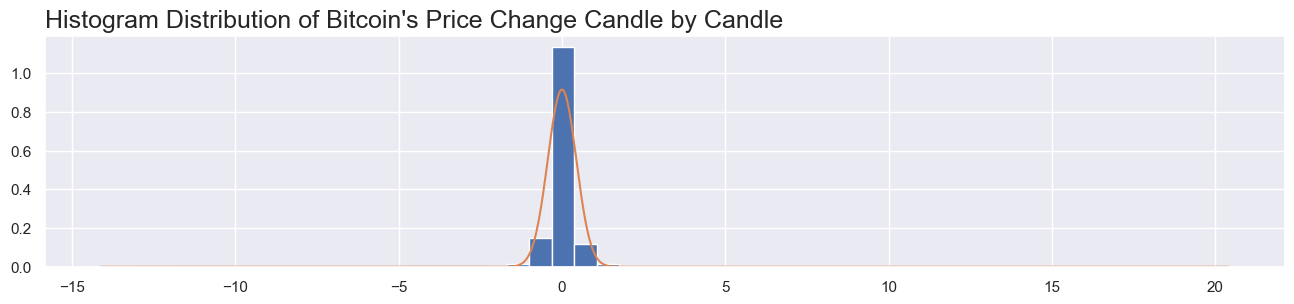

In [17]:
plt.hist(btc_return, bins=50, edgecolor='w', density=True)
overlay = np.linspace(mini, maxi, 1000)
plt.plot(overlay, norm.pdf(overlay, mean, std));

# Can not be described as normally distribuided

stats.ttest_1samp(btc_return.sample(252), 0, alternative='two-sided')
plt.title('Histogram Distribution of Bitcoin\'s Price Change Candle by Candle', fontsize=18, loc='left');

## New Features

In [11]:
# Was Last candle Bullish?
df['bull'] = np.where(df.close_price >= df.close_price.shift(1), True, False)

# What was the volatility of the last 4 hours?
df['volatility'] = (abs(df['high_price'] - df['low_price']) / df['open_price'] * 100).rolling(16).mean()

# How much the price has changed from the last candle?
df['change'] = btc_return / 100

# Calculate OBV indicator
df['OBV'] = np.where(df['close_price'] > df['close_price'].shift(1), df['volume'], -df['volume'])

# Calculate the Moving Average
df['MA25'] = df['close_price'].rolling(25).mean()
df['MA100'] = df['close_price'].rolling(100).mean()

# Search for the last top/bottom
df['top'] = np.where((df.high_price < df.high_price.shift(1))&(df.high_price.shift(1) > df.high_price.shift(2)), True, False)
df['bottom'] = np.where((df.low_price > df.low_price.shift(1))&(df.low_price.shift(1) < df.low_price.shift(2)), True, False)

# Calculate the last deep for each stock
df['last_bottom'] = df.rolling(window=16)['low_price'].min().shift(1)

# Calculate the last top for each stock
df['last_top'] = df.rolling(window=16)['high_price'].max().shift(1)

# Create traditional Top and Bottom
low_price = df.loc[df['bottom'].shift(-1) == True][['low_price']].rename(columns={'low_price':'low_bottom'})
high_price = df.loc[df['top'].shift(-1) == True][['high_price']].rename(columns={'high_price':'high_top'})

df = df.join(low_price)
df = df.join(high_price)

df['low_bottom'] = df['low_bottom'].ffill().shift(1)
df['high_top'] = df['high_top'].ffill().shift(1)

# Difference between the last and the actual top/bottom
df['last_bottom_difference'] = np.log(df.last_bottom).diff()
df['last_top_difference'] = np.log(df.last_top).diff()

df['low_bottom_difference'] = np.log(df.low_bottom).diff()
df['high_top_difference'] = np.log(df.high_top).diff()

### Predict Features

In [12]:
# Max/Min change in the next 4 hours (16 candles)
max_change = np.log(df['high_price'].shift(-16).rolling(16).max())
min_change = np.log(df['low_price'].shift(-16).rolling(16).min())
open_price = np.log(df['open_price'])

df['max_change'] = np.subtract(max_change, open_price)
df['min_change'] = np.subtract(min_change, open_price)

# Could a 2 Profit x 1 Loss obtain gain after this candle?
# Future feature

# Drop Not A Number (NaN) values
df = df.dropna()

In [13]:
df.head()

,close_price,high_price,low_price,open_price,taker_buy_base_asset_volume,volume,trades,bull,volatility,change,OBV,MA25,MA100,top,bottom,last_bottom,last_top,low_bottom,high_top,last_bottom_difference,last_top_difference,low_bottom_difference,high_top_difference,max_change,min_change
open_time,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02 01:00:00,13750.01,13770.00,13672.89,13715.00,55.636416,103.759210,1348,True,0.894587,0.0025,103.759210,13443.1204,13382.1761,True,False,13355.01,13850.0,13365.00,13850.0,0.0,0.010886,0.000000,0.025596,0.006178,-0.062037
2018-01-02 01:15:00,13662.13,13800.00,13659.45,13769.98,75.326408,160.355072,1450,False,0.878539,-0.0064,-160.355072,13464.2056,13383.2359,False,False,13355.01,13850.0,13365.00,13850.0,0.0,0.000000,0.000000,0.000000,-0.003817,-0.066037
2018-01-02 01:30:00,13686.00,13717.52,13662.16,13681.65,51.443940,89.270882,1225,True,0.870067,0.0017,89.270882,13485.6580,13384.8847,True,True,13355.01,13850.0,13659.45,13800.0,0.0,0.000000,0.021792,-0.003617,0.001529,-0.059602
2018-01-02 01:45:00,13636.41,13700.00,13600.00,13686.00,49.580078,135.893836,1495,False,0.866853,-0.0036,-135.893836,13503.1144,13386.5447,False,False,13355.01,13850.0,13659.45,13800.0,0.0,0.000000,0.000000,0.000000,0.001211,-0.059920
2018-01-02 02:00:00,13600.00,13702.59,13590.00,13648.90,40.579108,131.942135,1842,False,0.888312,-0.0027,-131.942135,13516.7020,13387.2546,False,False,13355.01,13850.0,13659.45,13800.0,0.0,0.000000,0.000000,0.000000,0.002154,-0.057206


In [14]:
n = np.random.randint(low=0, high=df.shape[0], size=1)[0]
new_df = df[n:n+72].copy()

fig = go.Figure(
    data=[
        go.Candlestick(
            x=new_df.index,
            open=new_df['open_price'],
            high=new_df['high_price'],
            low=new_df['low_price'],
            close=new_df['close_price'],
            name='Candlestick'
        ),
        go.Scatter(
            x=new_df.index,
            y=new_df['low_bottom'],
            line_color='brown',
            mode='lines',
            name='Bottom'
        ),
        go.Scatter(
            x=new_df.index,
            y=new_df['high_top'],
            line_color='green',
            mode='lines',
            name='Top'
        ),
        go.Scatter(
            x=new_df.index,
            y=new_df['MA25'],
            line_color='purple',
            mode='lines',
            name='MA25'
        ),
        go.Scatter(
            x=new_df.index,
            y=new_df['MA100'],
            line_color='sandybrown',
            mode='lines',
            name='MA100'
        )
    ]
).update_layout(xaxis_rangeslider_visible=False)

fig.update_layout(
    autosize=False,
    width=1500,
    height=800)

fig.show();

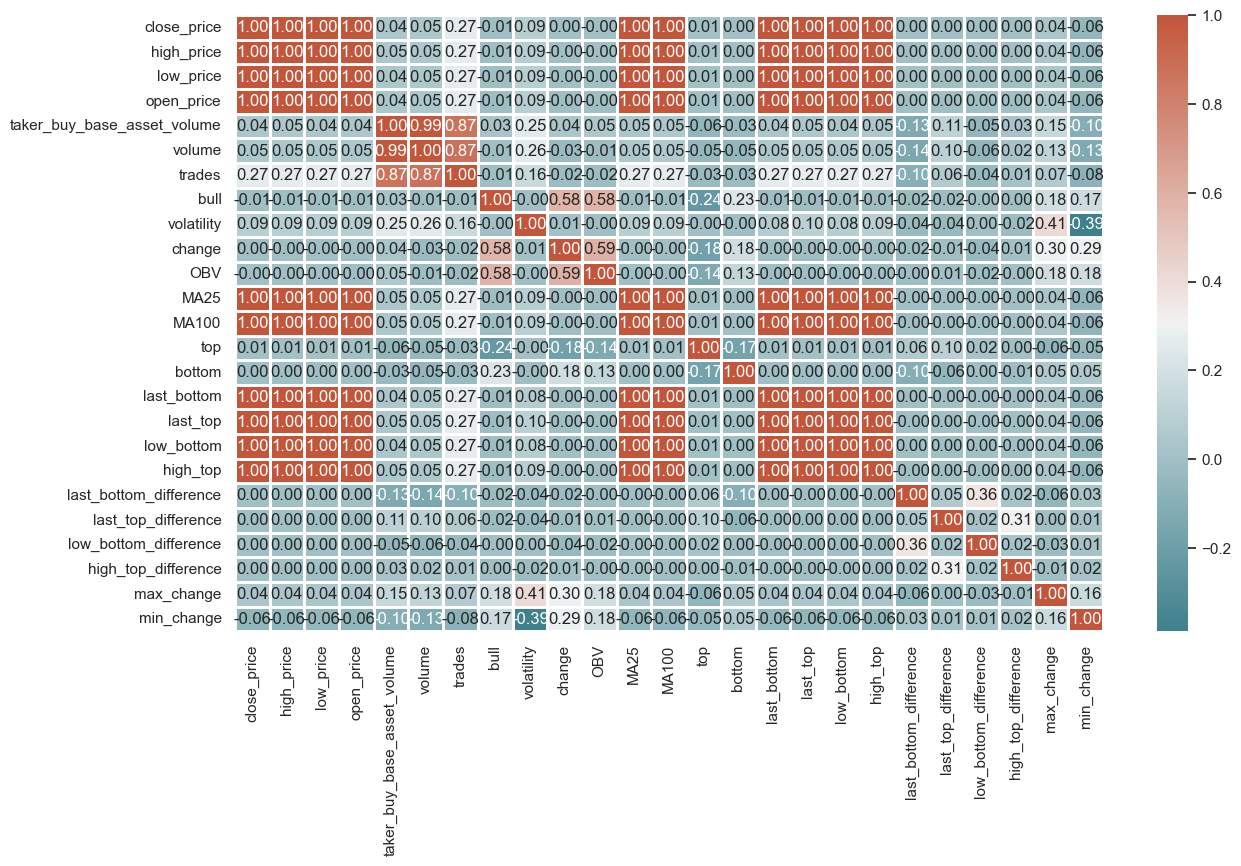

In [15]:
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=1, cmap=sns.diverging_palette(210, 20, as_cmap=True))

## Regression Algorithms

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score, r2_score
import pickle as cPickle

In [20]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### X and y split

In [21]:
X = df[[
    'close_price', 'high_price', 'low_price', 'open_price',
    'taker_buy_base_asset_volume', 'volume', 'trades', 'bull', 'volatility',
    'change', 'OBV', 'MA25', 'MA100', 'top', 'bottom', 'last_bottom',
    'last_top', 'low_bottom', 'high_top', 'last_bottom_difference',
    'last_top_difference', 'low_bottom_difference', 'high_top_difference'
]].copy()

y1 = df['max_change'].copy()
y2 = df['min_change'].copy()

In [22]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

### Hyperparameters tunning

In [25]:
SEED = 301
np.random.seed(SEED)

params = {
    'bootstrap':[True, False],
    'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_leaf':[2, 8, 16],
    'min_samples_split':[2, 5, 10],
    'n_estimators':[64, 128, 256, 384]
}

search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=params,
    n_iter=7,
    n_jobs=-1,
    cv=KFold(n_splits=2, shuffle=True),
    verbose=2,
    return_train_score=False,
)

search.fit(X, y1)

print(search.best_score_)
print(search.best_estimator_)

cPickle.dump(search.best_estimator_, open(f'search1.pkl', 'wb'))

Fitting 2 folds for each of 7 candidates, totalling 14 fits
0.2991766595970521
RandomForestRegressor(max_depth=70, min_samples_leaf=8, min_samples_split=5,
                      n_estimators=384)


Time spent: 83.6 minutes

Best Estimator: RandomForestRegressor(max_depth=70, min_samples_leaf=8, min_samples_split=5, n_estimators=384)

In [26]:
search.fit(X, y2)

print(search.best_score_)
print(search.best_estimator_)

cPickle.dump(search.best_estimator_, open(f'search2.pkl', 'wb'))

Fitting 2 folds for each of 7 candidates, totalling 14 fits
0.27248214672219695
RandomForestRegressor(max_depth=80, min_samples_leaf=8, n_estimators=64)


Time spent: 35.3 minutes

Best Estimator: RandomForestRegressor(max_depth=80, min_samples_leaf=8, n_estimators=64)

## Optimizing Dataset

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169093 entries, 2018-01-02 01:00:00 to 2022-12-07 20:15:00
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   close_price                  169093 non-null  float64
 1   high_price                   169093 non-null  float64
 2   low_price                    169093 non-null  float64
 3   open_price                   169093 non-null  float64
 4   taker_buy_base_asset_volume  169093 non-null  float64
 5   volume                       169093 non-null  float64
 6   trades                       169093 non-null  int64  
 7   bull                         169093 non-null  bool   
 8   volatility                   169093 non-null  float64
 9   change                       169093 non-null  float64
 10  OBV                          169093 non-null  float64
 11  MA25                         169093 non-null  float64
 12  MA100                   

In [21]:
def optimize_columns(df:object, precision:int) -> object:
    for column in df.columns:
        column_type = df[column].dtype

        if column_type == bool:
            continue

        elif column_type in ['float16', 'float32', 'float64', 'float128']:
            float_bits = [16, 32, 64, 128]
            bits = [3, 6, 15, 18]
            for bit in bits:
                if bit >= precision: break

            df[column] = df[column].astype(f'float{float_bits[bits.index(bit)]}')

        elif column_type in ['int8', 'int16', 'int32', 'int64']:
            max = df[column].max()
            min = df[column].min()

            for bit in [8, 16, 32, 64]:
                if min >= -2**(bit - 1) and max <= 2**(bit-1) - 1: break

            df[column] = df[column].astype(f'int{bit}')

        elif column_type in ['str', 'object']:
            print('str', column_type)
            df[column] = df[column].astype('category')

    return df

In [22]:
df = optimize_columns(df=df, precision=6)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169093 entries, 2018-01-02 01:00:00 to 2022-12-07 20:15:00
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   close_price                  169093 non-null  float32
 1   high_price                   169093 non-null  float32
 2   low_price                    169093 non-null  float32
 3   open_price                   169093 non-null  float32
 4   taker_buy_base_asset_volume  169093 non-null  float32
 5   volume                       169093 non-null  float32
 6   trades                       169093 non-null  int32  
 7   bull                         169093 non-null  bool   
 8   volatility                   169093 non-null  float32
 9   change                       169093 non-null  float32
 10  OBV                          169093 non-null  float32
 11  MA25                         169093 non-null  float32
 12  MA100                   

### Baseline

In [ ]:
from sklearn.model_selection import train_test_split

SEED = 301
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(X, pd.DataFrame(y1).join(y2), test_size=0.3)

model = RandomForestRegressor(n_jobs=-1)

model.fit(X_train, y_train['max_change'])

predict = model.predict(X_test)

y_test = pd.DataFrame(y_test)
y_test['predict'] = predict

y_test.head()

In [ ]:
relative_error = round((y_test.predict - y_test.max_change) / y_test.max_change * 100, 2)
relative_error = np.where(relative_error != np.inf, relative_error, 0)
relative_error.mean()

11.842897807916735

Without the Data optimization, the traning model took 13 minutes to complete. After optimizing it, it took 2.2 minutes to run.

The Baseline relative average error is about 11.84%.

## Model Validation

In [24]:
import pickle as cPickle

In [25]:
high_model = cPickle.load(open('search1.pkl', 'rb'))
low_model = cPickle.load(open('search2.pkl', 'rb'))

In [26]:
SEED = 301
np.random.seed(SEED)

high_model.fit(X_train, y_train['max_change'])
low_model.fit(X_train, y_train['min_change'])

predict_high = high_model.predict(X_test)
predict_low = low_model.predict(X_test)

y_test['max_predict'], y_test['min_predict'] = predict_high, predict_low

In [27]:
def mean_relative_error(predict_series:object, original_column:object, return_relative_error:bool=False) -> None or object:
    relative_error = round((predict_series - original_column) / original_column * 100, 2)
    print(relative_error.mean().round(2))

    if return_relative_error:
        return relative_error

y_test = y_test.query('max_change != 0 & min_change != 0')

mean_relative_error(y_test.max_predict, y_test.max_change)
mean_relative_error(y_test.min_predict, y_test.min_change)

-18.24
-112.52


The relative error using the Random Forest Regressor model is huge for trading. So a better option is traning a neural network to predict these values.